In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf

In [2]:
librosa.__version__

'0.8.1'

# Downloading sound file

In [3]:
filename = 'input/voice_recording.wav'
ipd.Audio(filename=filename)

In [4]:
sampling_rate = 22050
signal, sr = librosa.load(filename,sr=sampling_rate, mono=False)
signal.shape

(79360,)

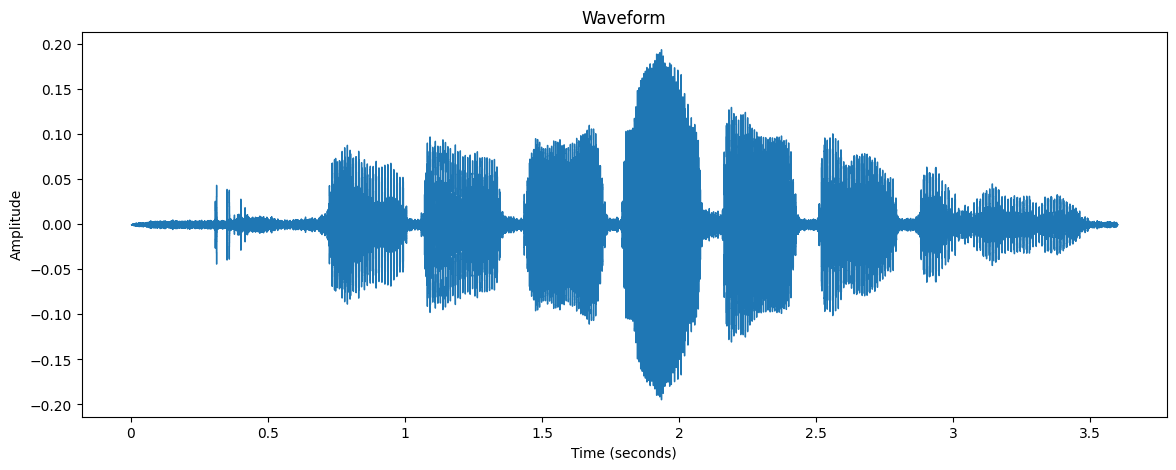

In [5]:
# Plot waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(signal, sr=sampling_rate)
plt.title('Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()
# plt.show()

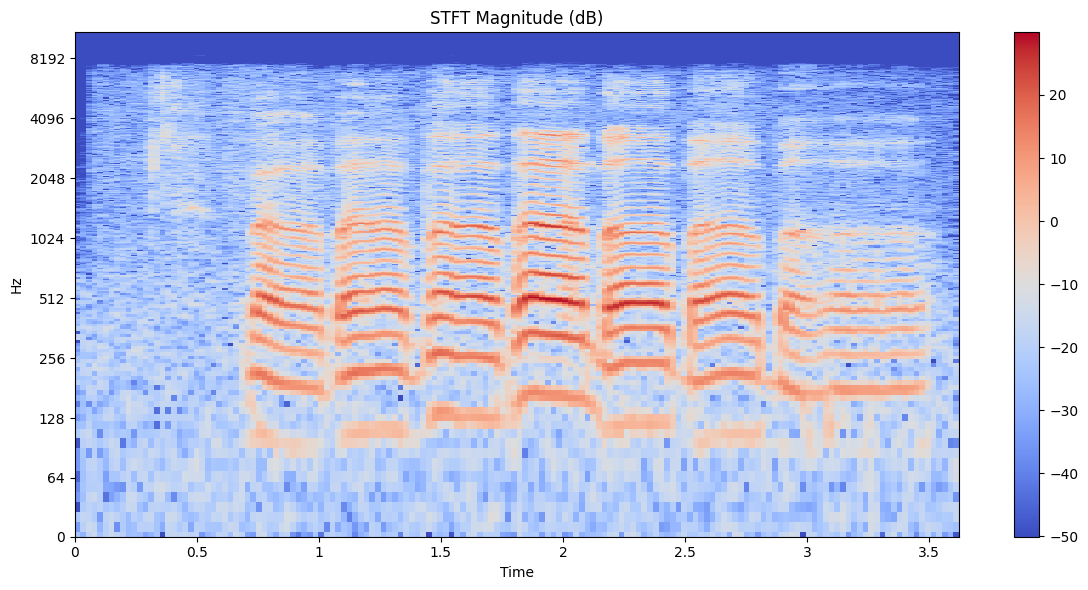

In [6]:

# Apply STFT
n_fft = 2048
hop_length = 512
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

# Get the magnitude and phase of the STFT
magnitude = librosa.magphase(stft)[0]
phase = librosa.magphase(stft)[1]

# Optional: Convert magnitude to decibels (dB)
magnitude_db = librosa.amplitude_to_db(magnitude)

# Optional: Visualize the STFT
plt.figure(figsize=(12, 6))
librosa.display.specshow(magnitude_db, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar()
plt.title('STFT Magnitude (dB)')
plt.tight_layout()
plt.show()


In [7]:
S_filter = librosa.decompose.nn_filter(magnitude, aggregate=np.median, metric='cosine', width=int(librosa.time_to_frames(2, sr=sampling_rate)))

S_filter = np.minimum(magnitude, S_filter)
margin_i, margin_v = 2, 10
power = 2
mask_i = librosa.util.softmask(S_filter,
                               margin_i * (magnitude - S_filter),
                               power=power)

mask_v = librosa.util.softmask(magnitude - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * magnitude
S_background = mask_i * magnitude
                                       

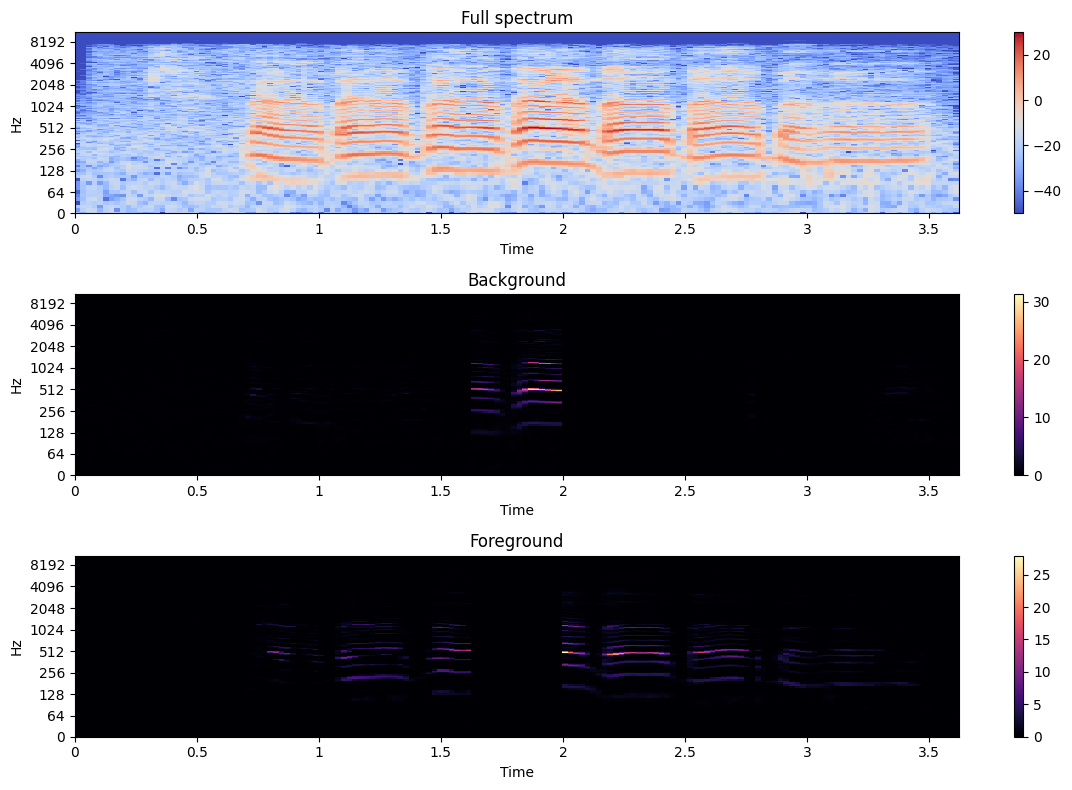

In [8]:
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(magnitude_db, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='log')
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)

librosa.display.specshow(S_background, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='log')
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(S_foreground, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='log')
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

In [9]:
y_foreground = librosa.istft(S_foreground * phase)
# Play back a 5-second excerpt with vocals
ipd.Audio(data=y_foreground, rate=sr)

# changing pitch

In [10]:
pitch_change = librosa.effects.pitch_shift(signal, sampling_rate, n_steps=1.1)
ipd.Audio(data=pitch_change, rate=sr)

# tracking the pitch

In [52]:
import librosa.core

# Estimate the pitch using YIN algorithm
f0, voiced_flag, _ = librosa.pyin(signal, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
f0

array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan, 106.25299618,
       108.11026584, 106.86851353, 103.82617439, 101.45478129,
        97.998859  ,  95.76056196,  94.6606581 ,  93.5733877 ,
        93.03444465,  91.96585291,  90.909535  ,  90.3859346 ,
        89.3477636 ,          nan,          nan, 102.63362907,
       104.4276333 , 107.48759653, 110.        , 110.63722352,
       110.        , 111.27813843, 112.57112812, 113.87914162,
       113.22324603, 111.92276613, 110.63722352, 108.11026584,
       102.63362907, 104.4276333 ,          nan, 133.09

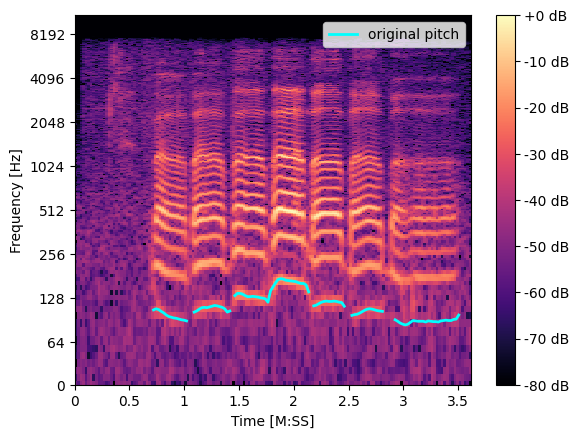

In [53]:
# Plot the pitch contour
 # pitch trajectory.
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
time_points = librosa.times_like(stft, sr=sr, hop_length=hop_length)
log_stft = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(log_stft, x_axis='time', y_axis='log', ax=ax, sr=sr, hop_length=hop_length)
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(time_points, f0, label='original pitch', color='cyan', linewidth=2)
# ax.plot(time_points, corrected_f0, label='corrected pitch', color='orange', linewidth=1)
ax.legend(loc='upper right')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [M:SS]')
plt.savefig('pitch_correction.png', dpi=300, bbox_inches='tight')



# Correcting the pitch

## Finding the nearest pitch

MIDI stands for Musical Instrument Digital Interface. It is a standard specifying a way in which software and electronic devices can transmit and receive music.

![MIDI-note table](./midi.png)

In [46]:
midis_from_hz

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan, 44.4, 44.7,
       44.5, 44. , 43.6, 43. , 42.6, 42.4, 42.2, 42.1, 41.9, 41.7, 41.6,
       41.4,  nan,  nan, 43.8, 44.1, 44.6, 45. , 45.1, 45. , 45.2, 45.4,
       45.6, 45.5, 45.3, 45.1, 44.7, 43.8, 44.1,  nan, 48.3, 48.9, 48.9,
       48.7, 48.3, 48. , 48. , 48.1, 48. , 47.9, 47.7, 47.6, 47.4, 46.5,
       49.6, 50.7, 51.8, 52.7, 52.9, 52.8, 52.5, 52.4, 52.3, 52.2, 52.1,
       51.8, 51.6, 51.6, 51.2, 49.3,  nan, 45.5, 45.7, 46.1, 46.5, 46.7,
       46.8, 46.7, 46.7, 46.8, 46.7, 46.5, 46.4, 45.4,  nan,  nan, 42.9,
       43.1, 43.2, 43.5, 43.9, 44.3, 44.6, 44.7, 44.6, 44.4, 44.2, 44.1,
       44. ,  nan,  nan,  nan,  nan, 41.7, 41.3, 40.8, 40.5, 40.3, 40.5,
       41. , 41.5, 41.4, 41.3, 41.3, 41.3, 41.1, 41.4, 41.3, 41.2, 41.2,
       41.1, 41.4, 41.5, 41.6, 41.5, 41.5, 41.8, 41

### rounding to the nearest whole number

In [55]:
midis_from_hz = librosa.hz_to_midi(f0)
nearest_midi = np.around(midis_from_hz)
nan_indices = np.isnan(f0)
nearest_midi[nan_indices] = np.nan
# convert back to frequency(hz)
corrected_f0_nearest = librosa.midi_to_hz(nearest_midi)

156
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False False False False False False False False False  True  True False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False  True
  True False False False False False False False False False False False
 False False  True  True  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True  True  True  True]


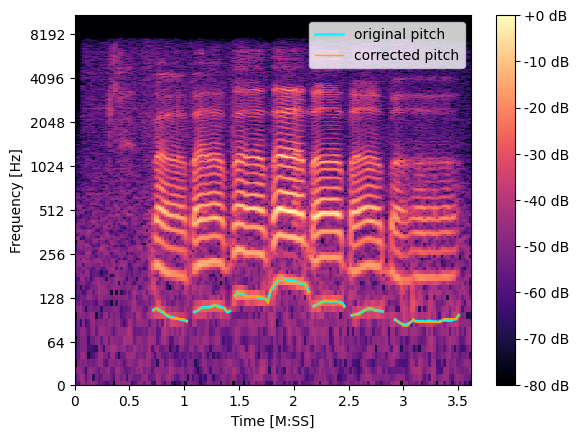

In [71]:
import psola

autotuned = psola.vocode(signal, sample_rate=int(sr), target_pitch=corrected_f0_nearest,fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

# ipd.Audio(data=autotuned, rate=sr)
# Plot the pitch contour
 # pitch trajectory.
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
time_points = librosa.times_like(stft, sr=sr, hop_length=hop_length)
log_stft = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(log_stft, x_axis='time', y_axis='log', ax=ax, sr=sr, hop_length=hop_length)
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(time_points, f0, label='original pitch', color='cyan', linewidth=2)
ax.plot(time_points, corrected_f0_nearest, label='corrected pitch', color='orange', linewidth=1)
ax.legend(loc='upper right')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [M:SS]')
plt.savefig('pitch_correction.png', dpi=300, bbox_inches='tight')

In [65]:
import numpy as np
# Compute the pitch correction factor
pitch_ratio = corrected_f0_nearest / f0
pitch_ratio[f0 <= 0] = 1.0
pitch_ratio[np.isnan(f0)] = 1.0
print(len(pitch_ratio))
print(len(f0)*512)
print(len(signal))

156
79872
79360


In [69]:
signal_autotuned = np.zeros_like(signal)
for i in range(0, len(signal), hop_length):
    signal_autotuned[i:i+hop_length] = librosa.effects.pitch_shift(
    signal[i:i+hop_length], sr, n_steps=np.log2(pitch_ratio[int(i/512)]), bins_per_octave=12)

ipd.Audio(data=signal_autotuned, rate=sr)

In [82]:
degrees = np.concatenate((degrees, [degrees[0] + 12]))


# exile by tayloy swift
scale = 'Gb:maj'


for i in range(0, len(f0)):
    f0[i]
    degrees = librosa.key_to_degrees('Gb:maj')
    print(degrees)
    midi_note = librosa.hz_to_midi(f0[i]


[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 1

In [84]:
degrees = np.concatenate((degrees, [degrees[0] + 12]))


# exile by tayloy swift
scale = 'Gb:maj'


for i in range(0, len(f0)):
    f0[i]
    degrees = librosa.key_to_degrees(scale)
    print(degrees)
    
    midi_note = librosa.hz_to_midi(f0[i])
    degree = midi_note % 12 # number of semitones in an octave

    degree_id = np.argmin(np.(degrees))


[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 11  1  3  5]
[ 6  8 10 1